# Principal Component Analisis

Welcome to your next lab! In this assignment you will explore problem of reducing dimensionality of data and restoring it back using your PCA model.


**You will learn to:**
- Build the general architecture of a learning algorithm with OOP in mind:
    - Helper functions
        - Normalization
        - Eigendecomposition
    - PCA Class
        - Transform
        - Restore

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pypi.org/project/PIL/) is the Python Imaging Library.
- [mpl_toolkits](https://matplotlib.org/mpl_toolkits/index.html) collections of application-specific functions that extend Matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

## 2 - Overview of the Problem set ##

**Problem Statement**: 
In this assignment we have an image as dataset. We will reduce its dimensionality using our algorithm. Here it is represented as array with dimension (1280, 960).

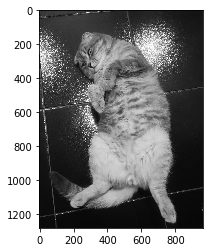

In [2]:
img = Image.open('cat2.jpeg')
img = img.convert('L', colors=256)
img = np.array(img, dtype=np.uint8)
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [3]:
print('Shape of image:', img.shape)

Shape of image: (1280, 960)


**Expected Output**: 

Shape of image: (1280, 960)

But firstly we will check performance of PCA on simple synthetic dataset, which includes 13 examples with 3 features:

In [4]:
X = np.asarray([[12, 15, 20, 24, 27, 30, 63, 8, 67, 43, 11, 15, 67], 
                [34, 31, 29, 88, 76, 80, 89, 53, 48, 66, 45, 50, 85], 
                [45, 50, 43, 60, 65, 59, 89, 53, 43, 31, 33, 40, 80]]).T
print('Shape of input data:', X.shape)

Shape of input data: (13, 3)


**Expected output:**
    
Shape of input data: (13, 3)

Let's visualize it:


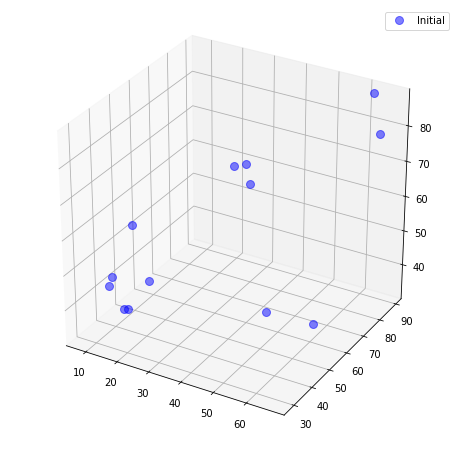

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(X.T[0,:], X.T[1,:], X.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='Initial')

ax.legend(loc='upper right')

plt.show()

## 3 -  Principal Component Analisis. General Architecture
**Mathematical expression of the algorithm**:

Principal Component Analysis (PCA) is a simple linear transformation technique that is used in numerous applications, such as stock market predictions, the analysis of gene expression data, and many more. 

Steps of the algorithm:
- Standardize the data;
- Obtain the Eigenvectors and Eigenvalues from the covariance matrix;
- Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace $(k≤$n_features);
- Construct the projection matrix $W$ from the selected $k$ eigenvectors;
- Transform the original dataset $X$ via $W$ to obtain a $k$-dimensional feature subspace $Y$.

### 3.1 -  Eigendecomposition: Computing Eigenvectors and Eigenvalues, 

**Standardizing the data**

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. 

Let's transform the data onto unit scale, which is a requirement for the optimal performance of many machine learning algorithms. We will do it using standard score:
$$z = \frac{x - \mu}{\sigma}\tag{1}$$

In [6]:
# GRADED FUNCTION: normalize

def normalize(X):
    """
    Normalise data before processing
    
    Arguments:
    X -- matrix of input features of shape (n_examples, n_features)
    
    Returns:
    X_norm -- normalized matrix of shape (n_examples, n_features)
    norm_parameters -- matrix of normalization parameters, such as mean and std by columns;
        shape (2, n_features)
        
    """
    
    ### START CODE HERE ### 
    #arr = np.array([[1, 2, 3], [4, 5, 6]])
    X_norm = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)
    X_mean  = np.mean(X, axis = 0)
    #print(X)
    #print(X_mean)
   
    X_st_dev = np.std(X, axis = 0)
    #print(X_st_dev)
    norm_parameters = np.array([[X_mean], [X_st_dev]])
    #print(norm_parameters[0][0])
    ### END CODE HERE ###

    return X_norm, norm_parameters

In [7]:
norm_test, norm_pars_test = normalize(X)
print('Normalized:')
print(norm_test[0])
print('Parameters:')
print(norm_pars_test)

Normalized:
[-0.89985013 -1.19521931 -0.49137306]
Parameters:
[[[30.92307692 59.53846154 53.15384615]]

 [[21.02914292 21.36717607 16.59400334]]]


**Expected Output**: 

<table style="width:60%">
    <tr>
        <td style="width:10%"><b>Normalized:</b></td>
       <td> [-0.89985013 -1.19521931 -0.49137306]</td>
    </tr>
    <tr>
        <td><b>Parameters:</b></td>
       <td>[[30.92307692 59.53846154 53.15384615]<br>
 [21.02914292 21.36717607 16.59400334]]</td>
    </tr>
</table>

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

**Covariance Matrix**

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $Σ$, which is a $n_{features}×n_{features}$ matrix where each element represents the covariance between two features.

We can summarize the calculation of the covariance matrix via the following matrix equation:
$$\Sigma_{ij} = \frac{1}{N} \sum_{n=1}^{N} (x(n)_i – {\bar{x}}_i)(x(n)_j – {\bar{x}}_j)\tag{2}$$
where $\bar{x}$ is the mean vector ${\bar{x}} = \sum\limits_{k=1}^n x_{k}$.
The mean vector is a $n_{features}$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.


**Correlation Matrix**

A correlation matrix is used if the variances of individual variates differ much, or if the units of measurement of the individual variates differ.

$$\Sigma_{ij} = \frac{c_{ij}}{\sqrt{c_{ii}c_{jj}}},\tag{3}$$
where $x$ - elements of covariation matrix.


**SVD**

While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency. 

To perform SVD in the right way we need to transpose the input matrix, so $X^T$ will have dimension $n_{features}×n_{samples}$. Let us assume that it is centered, i.e. column means have been subtracted and are now equal to zero.

Then the $n_{features}×n_{features}$ covariance matrix $C$ is given by $$C=X^TX/(n_{samples}−1).\tag{4}$$ It is a symmetric matrix and so it can be diagonalized: $$C = ULU^T,\tag{5}$$
where $U$ is a matrix of eigenvectors (each column is an eigenvector) and $L$ is a diagonal matrix with eigenvalues $λ_i$ in the decreasing order on the diagonal. The eigenvectors are called principal axes or principal directions of the data. Projections of the data on the principal axes are called principal components, also known as PC scores; these can be seen as new, transformed, variables. The $j$-th principal component is given by $j$-th column of $X^TV$. The coordinates of the $i$-th data point in the new PC space are given by the $i$-th row of $UX^T$.

If we now perform singular value decomposition of $X^T$, we obtain a decomposition
$$X^T=USV^T,\tag{6}$$
where $U$ is a unitary matrix and $S$ is the diagonal matrix of singular values $s_i$. From here one can easily see that $$C = USV^TVSU^T/(n_{samples}-1) = U \frac{S^2}{n_{samples}-1}U^T,\tag{7}$$
meaning that right singular vectors $U$ are principal directions and that singular values are related to the eigenvalues of covariance matrix via $λ_i=s^2_i/(n_{samples}−1)\tag{8}$.

In [97]:
# GRADED CLASS: Eigendecomposition

class Eigendecomposition():
        
    def covariance(self, X):
        """
        Calculates eigenvectors and eigenvalues of covariance matrix
        Arguments:
        
        X -- normalized input matrix with shape (n_examples, n_features) 
        
        Returnes:
        
        eig_vals -- array of eigenvalues with shape (n_features, )
        eig_vecs -- matrix of eigenvectors with shape (n_features, n_features)
        """
        
        ### START CODE HERE ###
        #X_mean  = np.mean(X, axis = 0)
        #cov_mat = (X - X_mean).T.dot((X - X_mean)) / (X.shape[0])
        cov_mat = np.cov(X.T)
        
        #print("cov_mat:", cov_mat)
        e_val, e_vect = np.linalg.eig(cov_mat)
        #print(e_val, e_vect)
        ### END CODE HERE ###
        return e_val, e_vect
        
    def correlation(self, X):
        """
        Calculates eigenvectors and eigenvalues of correlation matrix
        Arguments:
        
        X -- normalized input matrix with shape (n_examples, n_features) 
        
        Returnes:
        
        eig_vals -- array of eigenvalues with shape (n_features, )
        eig_vecs -- matrix of eigenvectors with shape (n_features, n_features)
        """
        
        ### START CODE HERE ###
        
        cor_mat = np.corrcoef(X.T)
        #print("cor_mat:", cor_mat)
        e_val, e_vect = np.linalg.eig(cor_mat)
        #print(e_val, e_vect)

        ### END CODE HERE ###
        return e_val, e_vect
    
    def svd(self, X):
        """
        Calculates eigenvectors and eigenvalues by svd
        Arguments:
        
        X -- normalized input matrix with shape (n_examples, n_features)
        
        Returnes:
        
        eig_vals -- array of eigenvalues with shape (n_features, )
        eig_vecs -- matrix of eigenvectors with shape (n_features, n_features)
        """
        
        ### START CODE HERE ###
        #u,s,v
        e_vect, singular_values, v= np.linalg.svd(X.T)
        #print("e_val,e_vect of SVD: ", e_val, e_vect)
        ### END CODE HERE ###
        return singular_values**2/(X.shape[0]-1), e_vect
        

In [98]:
cov_vals, cov_vects = Eigendecomposition().covariance(norm_test)

for ev in cov_vects:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [99]:
cor_vals, cor_vects = Eigendecomposition().correlation(norm_test)

for ev in cor_vects:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [100]:
svd_vals, svd_vects = Eigendecomposition().svd(norm_test)

for ev in svd_vects:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


### 3.2-3.3 - Selecting Principal Components, Projection Onto the New Feature Space

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. 

In order to decide which eigenvector(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data - those are the ones can be dropped.

So now we need to implement following steps:
1. Compute eigenvectors $(e_1,e_2,...,e_d)$ and corresponding eigenvalues $(λ_1,λ_2,...,λ_d)$.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.
2. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $n_{features}×k$ dimensional matrix $W$ (where every row represents an eigenvector)
3. Use this $n_{features}×k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $$Y=X_{normalized}×W\tag{9}$$ (where $X_{normalized}$ is an normalized input matrix with shape $n_{samples}×n_{features}$, and $Y$ is the transformed $n_{samples}×k$-dimensional matrix of samples in the new subspace.)

4. To restore input matrix $X$ we should do next operation: $$X_{restored} = Y×W^T.\tag{10}$$ But don't forget that we worked with normalized data, so we also have to put it to the initial form back (use `norm_parameters` from `normalization` function).

In [113]:
# GRADED CLASS: PCA

class PCA():
    """
    Parameters:
    -----------
    X -- matrix of input features of shape (n_examples, n_features) 
    n -- number of principal components
    """
    
    def __init__(self, X, n, eigendecomposition):
        self.X = X
        self.n = n
        self.eigendecomposition = eigendecomposition
        self.X_norm = None
        self.norm_params = None
        
        
    def transform(self):
        """
        Transforms the samples into the new subspace
        
        Returns:
        transformed -- reduced matrix of input features with shape (n_samples, n)
        matrix_w -- matrix of n eigenvectors with largest eigenvalues with shape (n_features, n)
        """
        
        ### START CODE HERE ###
        self.X_norm, self.norm_parameters = normalize(self.X)
        e_val, e_vect = self.eigendecomposition(self.X_norm)
        print(e_val.shape)
        
        print(e_vect.shape)
       
        # Make a list of (eigenvalue, eigenvector) tuples
        eig_pairs = [(e_val[i], e_vect.T[i]) for i in range(len(e_val))]
        #print(eig_pairs)
        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        #print("sorted: ", eig_pairs)

        #print("self.n:", self.n)
        lst = []
        for i in eig_pairs:
            lst.append(i[1])
                
        #print("list is: ", lst)
        lst1 = lst[:self.n]
        self.matrix_w = np.array(lst1)
        print(self.matrix_w.shape)
        #print(matrix_w)
#         print(matrix_w.shape)
        print(self.X_norm.shape)
        self.transformed = np.dot(self.X_norm, self.matrix_w.T)
        #print(transformed)
        #print(transformed.shape)
        ### END CODE HERE ###

        return self.transformed, self.matrix_w

        
    def restore(self):
        """
        Restores "original" values

        Returns:
        matrix with shape (n_features, n_examples), 
            containing restored values depending on reduced input matrix of features   
        """
        
        ### START CODE HERE ###
        
        X_res = np.dot(self.transformed, self.matrix_w)*self.norm_parameters[1]+self.norm_parameters[0]
        
        return X_res
        ### END CODE HERE ###

After completing all steps, the next question is “how many principal components are we going to choose for our new feature subspace?” A useful measure is the so-called “explained variance,” which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

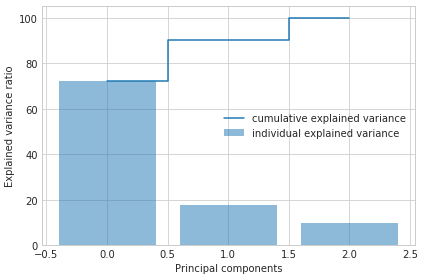

In [114]:
tot = sum(cov_vals)
var_exp = [(i / tot)*100 for i in sorted(cov_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

The plot above clearly shows that most of the variance (~77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (~19%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain ~96% of the information.



Initialize model:

In [115]:
pca = PCA(X, 2, Eigendecomposition().correlation)

Reducing of input matrix dimencion:

In [116]:
reduced_x, reduced_eigenvects = pca.transform()
print('Reduced input matrix:')
print(reduced_x[:5])

(3,)
(3, 3)
(2, 3)
(13, 3)
Reduced input matrix:
[[-1.49086967 -0.15159675]
 [-1.3199115  -0.10840709]
 [-1.50049321  0.29895991]
 [ 0.87097958 -0.90026658]
 [ 0.7886636  -0.71439948]]


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td style="width:15%">
           <b>Reduced input matrix:</b>
       </td>
       <td> [[-1.49086967 -0.15159675]<br>
 [-1.3199115  -0.10840709]<br>
 [-1.50049321  0.29895991]<br>
 [ 0.87097958 -0.90026658]<br>
 [ 0.7886636  -0.71439948]]
    </tr>
</table>

Let's plot our reduced data and compare it with original:

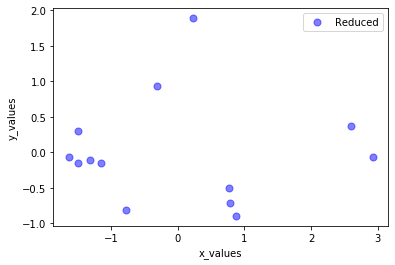

In [117]:
plt.plot(reduced_x.T[0,:], reduced_x.T[1,:], 'o', markersize=7, color='blue', alpha=0.5, label='Reduced')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()

plt.show()

Now let's restore "original" values by the reduced:

In [118]:
new_x = pca.restore()
print('Restored:')
print(new_x[:5])

Restored:
[[11.51573657 41.48068378 39.47263947]
 [14.1995759  43.36459173 40.86399609]
 [19.41116905 38.09599585 36.27911059]
 [24.69623033 77.24494687 67.94674095]
 [27.07495924 74.84206341 65.85558128]]


**Expected Output**: 

<table style="width:60%">
    <tr>
       <td style="width:10%">
           <b>Restored:</b>
       </td>
       <td> [[11.51573657 41.48068378 39.47263947]<br>
 [14.1995759  43.36459173 40.86399609]<br>
 [19.41116905 38.09599585 36.27911059]<br>
 [24.69623033 77.24494687 67.94674095]<br>
 [27.07495924 74.84206341 65.85558128]]
    </tr>
</table>

Visualising of restored values:

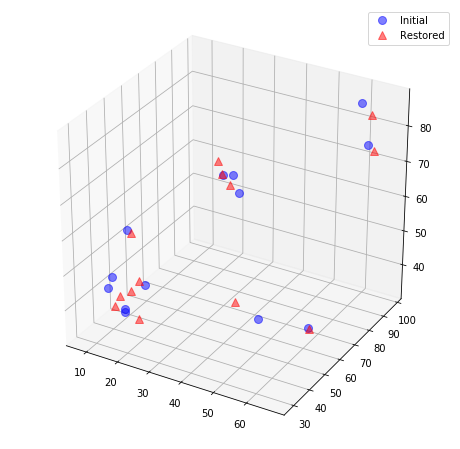

In [119]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X.T[0,:], X.T[1,:], X.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='Initial')
ax.plot(new_x.T[0,:], new_x.T[1,:], new_x.T[2,:], '^', markersize=8, alpha=0.5, color='red', label='Restored')

ax.legend(loc='upper right')


plt.show()

## 4 - Trying the Algorithm on Image

Initializing the model for processing our data:

In [120]:
pca_img = PCA(img, 50, Eigendecomposition().covariance)

In [121]:
reduced_img, reduced_eigenvects_img = pca_img.transform()
print('Reduced array:')
print(reduced_img.shape)

(960,)
(960, 960)
(50, 960)
(1280, 960)
Reduced array:
(1280, 50)


**Expected Output**: 

<table style="width:25%">
    <tr>
       <td>
        <b>Reduced array:</b>
       </td>
       <td> (1280, 50)
    </tr>
</table>

Now let's restore the image and compare it with original:

In [122]:
restored_img = pca_img.restore()

Initial:


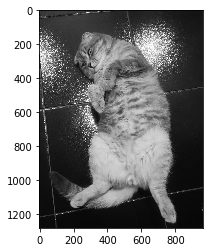

In [123]:
imgplot = plt.imshow(img, cmap='gray')
print('Initial:')
plt.show()


Restored:


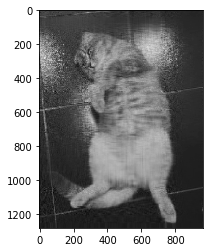

In [124]:
imgplot = plt.imshow(restored_img, cmap='gray')
print('Restored:')
plt.show()

## 5 - Conclusion

As we can see, our algorithm solves problem of reducing dimension of data well.

**What's next:**
1. Try to experiment with different ways of eigendecomposition and values of k.
2. Compare the results you have obtained with the `sklearn.decomposition.PCA`.
3. Try this model in the wild! Select your favorite dataset [here](https://www.kaggle.com/datasets?sortBy=hottest&group=public&page=1&pageSize=20&size=small&filetype=all&license=all&tagids=13303) and play with it.